In [ ]:
import os
import six
import requests
import numpy as np
import torch
import torch.nn as nn
import warnings
import argparse
import json
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import random
import torch.distributions as D
import torch.nn.functional as F
import math
import torch.nn.utils.rnn as rnn_utils
import time
from tqdm import tqdm
import torch.optim as optim
import shutil
from argparse import Namespace
import matplotlib.pyplot as plt
import numbers

In [ ]:
__all__ = ['hparam_parser', 'hparams']



def hparam_parser():
    parser = argparse.ArgumentParser(add_help=False)
    group = parser.add_argument_group('hyperparameters')

    # architecture params
    group.add_argument('--max_seq_len', type=int, default=250)
    group.add_argument('--enc_model', type=str, default='lstm') #
    group.add_argument('--dec_model', type=str, default='layer_norm')
    group.add_argument('--enc_rnn_size', type=int, default=256)
    group.add_argument('--dec_rnn_size', type=int, default=512)
    group.add_argument('--z_size', type=int, default=128)
    group.add_argument('--num_mixture', type=int, default=20)
    group.add_argument('--r_dropout', type=float, default=0.1)
    #group.add_argument('--input_dropout', type=float, default=0.0) # Not recommended
    #group.add_argument('--output_dropout', type=float, default=0.0) # Not recommended

    # loss params
    group.add_argument('--kl_weight', type=float, default=0.5)
    group.add_argument('--kl_weight_start', type=float, default=0.01) # eta_min
    group.add_argument('--kl_tolerance', type=float, default=0.2) # kl_min
    group.add_argument('--kl_decay_rate', type=float, default=0.99995) # R
    group.add_argument('--reg_covar', type=float, default=1e-6) # covariance shrinkage

    # training params
    group.add_argument('--batch_size', type=int, default=100)
    group.add_argument('--lr', type=float, default=0.001)
    group.add_argument('--lr_decay', type=float, default=0.9999)
    group.add_argument('--min_lr', type=float, default=0.00001) # UNUSED
    group.add_argument('--grad_clip', type=float, default=1.0)

    # dataset & data augmentation params
    group.add_argument('--data_set', type=str, default=['cat.npz','car.npz'])
    group.add_argument('--random_scale_factor', type=float, default=0.15)
    group.add_argument('--augment_stroke_prob', type=float, default=0.10)
    group.add_argument('--data_dir', type=str, default='data')
    group.add_argument('--save_dir', type=str, default='results')
    group.add_argument('--num_epochs',type=int,default=30)
    group.add_argument('--num_workers',type=int,default=0)

    return parser


def hparams(**kwargs):
    parser = hparam_parser()
    hps = parser.parse_args([])
    for key,val in kwargs.items():
        if not hasattr(hps, key):
            warnings.warn("A non-standard hyperparam '%s' was specified." % key)
        setattr(hps, key, val)
    return hps

In [ ]:
def get_max_len(strokes):
    """Return the maximum length of an array of strokes."""
    max_len = 0
    for stroke in strokes:
        ml = len(stroke)
        if ml > max_len:
            max_len = ml
    return max_len

def to_tensor(x):
    if isinstance(x, torch.Tensor):
        pass
    elif isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    else:
        raise Exception('input must be a tensor or ndarray.')
    return x.float()

__all__ = ['load_strokes', 'SketchRNNDataset', 'collate_drawings']

# start-of-sequence token
SOS = torch.tensor([0, 0, 1, 0, 0], dtype=torch.float)


def load_strokes(data_dir, hps):
    """Loads the .npz file, and splits the set into train/valid/test."""

    # normalizes the x and y columns using the training set.
    # applies same scaling factor to valid and test set.

    if isinstance(hps.data_set, list):
        datasets = hps.data_set
    else:
        datasets = [hps.data_set]

    train_strokes = None
    valid_strokes = None
    test_strokes = None

    for dataset in datasets:
        # First check if file exists locally
        local_filepath = os.path.join(data_dir, dataset)

        if os.path.exists(local_filepath):
            print(f'Loading local file: {local_filepath}')
            data = np.load(local_filepath, encoding='latin1', allow_pickle=True)
        else:
            # If not local, try downloading from Google Cloud Storage
            base_url = 'https://storage.googleapis.com/quickdraw_dataset/sketchrnn/'
            data_filepath = base_url + dataset
            print('Downloading %s' % data_filepath)

            try:
                response = requests.get(data_filepath)
                response.raise_for_status()  # Raise an exception for bad status codes

                # Ensure data_dir exists before saving
                os.makedirs(data_dir, exist_ok=True)

                # Save the downloaded file
                with open(local_filepath, 'wb') as f:
                    f.write(response.content)

                # Load the saved file with pickle support
                data = np.load(local_filepath, encoding='latin1', allow_pickle=True)
                print(f'Downloaded and saved {dataset} to {local_filepath}')
            except Exception as e:
                print(f"Error downloading {dataset}: {e}")
                continue

        print('Loaded {}/{}/{} from {}'.format(
            len(data['train']), len(data['valid']), len(data['test']), dataset))

        if train_strokes is None:
            train_strokes = data['train']
            valid_strokes = data['valid']
            test_strokes = data['test']
        else:
            train_strokes = np.concatenate((train_strokes, data['train']))
            valid_strokes = np.concatenate((valid_strokes, data['valid']))
            test_strokes = np.concatenate((test_strokes, data['test']))

    all_strokes = np.concatenate((train_strokes, valid_strokes, test_strokes))
    num_points = 0
    for stroke in all_strokes:
        num_points += len(stroke)
    avg_len = num_points / len(all_strokes)
    print('Dataset combined: {} ({}/{}/{}), avg len {}'.format(
        len(all_strokes), len(train_strokes), len(valid_strokes),
        len(test_strokes), int(avg_len)))

    # calculate the max stroke len and overwrite hps
    hps.max_seq_len = get_max_len(all_strokes)
    print('hps.max_seq_len %i.' % hps.max_seq_len)

    return train_strokes, valid_strokes, test_strokes


class SketchRNNDataset:
    def __init__(self,
                 strokes,
                 max_len=250,
                 scale_factor=None,
                 random_scale_factor=0.0,
                 augment_stroke_prob=0.0,
                 limit=1000):
        strokes = [to_tensor(stk) for stk in strokes]
        self.max_len = max_len  # N_max in sketch-rnn paper
        self.random_scale_factor = random_scale_factor  # data augmentation method
        self.augment_stroke_prob = augment_stroke_prob  # data augmentation method
        self.limit = limit # clamp x-y offsets to range (-limit, limit)
        self.preprocess(strokes) # list of drawings in stroke-3 format, sorted by size
        self.normalize(scale_factor)

    def preprocess(self, strokes):
        """Remove entries from strokes having > max_len points.
        Clamp x-y values to (-limit, limit)
        """
        raw_data = []
        seq_len = []
        count_data = 0
        for i in range(len(strokes)):
            data = strokes[i]
            if len(data) <= (self.max_len):
                count_data += 1
                data = data.clamp(-self.limit, self.limit)
                raw_data.append(data)
                seq_len.append(len(data))
        self.sort_idx = np.argsort(seq_len)
        self.strokes = [raw_data[ix] for ix in self.sort_idx]
        print("total drawings <= max_seq_len is %d" % count_data)

    def calculate_normalizing_scale_factor(self):
        """Calculate the normalizing factor explained in appendix of sketch-rnn."""
        strokes = [elt for elt in self.strokes if len(elt) <= self.max_len]
        data = torch.cat(strokes)
        return data[:,:2].std()

    def normalize(self, scale_factor=None):
        """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
        if scale_factor is None:
            scale_factor = self.calculate_normalizing_scale_factor()
        self.scale_factor = scale_factor
        for i in range(len(self.strokes)):
            self.strokes[i][:,:2] /= self.scale_factor

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        data = self.strokes[idx]
        if self.random_scale_factor > 0:
            data = random_scale(data, self.random_scale_factor)
        if self.augment_stroke_prob > 0:
            data = random_augment(data, self.augment_stroke_prob)
        return data


def random_scale(data, factor):
    """Augment data by stretching x and y axis randomly [1-e, 1+e]."""
    data = data.clone()
    x_scale = (torch.rand(()) - 0.5) * 2 * factor + 1.0
    y_scale = (torch.rand(()) - 0.5) * 2 * factor + 1.0
    data[:,0] *= x_scale
    data[:,1] *= y_scale
    return data

def random_augment(data, prob):
    """Perform data augmentation by randomly dropping out strokes."""
    # drop each point within a line segments with a probability of prob
    # note that the logic in the loop prevents points at the ends to be dropped.
    data = data.clone()
    result = []
    prev_stroke = [0, 0, 1]
    count = 0
    stroke = [0, 0, 1]  # Added to be safe.
    for i in range(len(data)):
        candidate = [data[i][0], data[i][1], data[i][2]]
        if candidate[2] == 1 or prev_stroke[2] == 1:
            count = 0
        else:
            count += 1
        check = candidate[2] == 0 and prev_stroke[2] == 0 and count > 2
        if check and (torch.rand(()) < prob):
            stroke[0] += candidate[0]
            stroke[1] += candidate[1]
        else:
            stroke = candidate
            prev_stroke = stroke
            result.append(stroke)
    result = torch.tensor(result, dtype=torch.float)
    return result



# ---- methods for batch collation ----

def pad_batch(sequences, max_len):
    """Pad the batch to be stroke-5 bigger format as described in paper."""
    batch_size = len(sequences)
    output = torch.zeros(batch_size, max_len+1, 5)
    for i in range(batch_size):
        seq, out = sequences[i], output[i]
        l = len(seq)
        assert l <= max_len
        # fill sos value
        out[0] = SOS
        # fill remaining values
        out = out[1:]
        out[:l,:2] = seq[:,:2]
        out[:l,3] = seq[:,2]
        out[:l,2] = 1 - out[:l,3]
        out[l:,4] = 1
    return output

def collate_drawings(sequences, max_len):
    lengths = torch.tensor([len(seq) for seq in sequences],
                           dtype=torch.long)
    batch = pad_batch(sequences, max_len)
    return batch, lengths

In [ ]:
__all__ = ['tikhonov_reg2d', 'compute_cov2d', 'sample_gmm']

def tikhonov_reg2d(scales, corrs, alpha):
    """Adds a non-negative constant to the diagonal of the covariance
    matrix for a 2D multivariate normal ("tikhonov regularization").
    """
    scales_ = torch.sqrt(scales**2 + alpha)
    corrs_ = corrs * torch.prod(scales, -1) / torch.prod(scales_, -1)
    return scales_, corrs_

def compute_cov2d(scales, corrs):
    """
    Compute covariance matrix for 2D multivariate normal

    Parameters
    ----------
    scales: Tensor[...,d]
    corrs: Tensor[...]
    """
    # compute covariances
    cov12 = corrs*torch.prod(scales,dim=-1) # (...,)
    covs = torch.diag_embed(scales**2) # (...,d,d)
    I = torch.diag_embed(torch.ones_like(scales)) # (...,d,d)
    covs = covs + cov12.unsqueeze(-1).unsqueeze(-1)*(1.-I)
    return covs


def sample_gmm(mix_logp, means, scales, corrs):
    covs = compute_cov2d(scales, corrs)
    mix = D.Categorical(mix_logp.exp())
    comp = D.MultivariateNormal(means, covs)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm.sample()

In [ ]:
__all__ = ['KLLoss', 'DrawingLoss']

# ---- KL Divergence loss ----

def kl_divergence_sn_prior(q_mean, q_logvar):
    """KL with standard normal prior (default)"""
    kl = -0.5 * (1 + q_logvar - q_mean ** 2 - torch.exp(q_logvar))
    return kl.mean()

def kl_divergence(q_mean, q_logvar, p_mean=None, p_logvar=None):
    if p_mean is None and p_logvar is None:
        return kl_divergence_sn_prior(q_mean, q_logvar)
    if p_mean is None: p_mean = torch.zeros_like(q_mean)
    if p_logvar is None: p_logvar = torch.zeros_like(q_logvar)
    kl = p_logvar - q_logvar + \
        (q_logvar.exp() + (q_mean - p_mean)**2) / p_logvar.exp() - 1
    kl = 0.5 * kl
    return kl.mean()

class KLLoss(nn.Module):
    def __init__(self, kl_weight=1., eta_min=0.01, R=0.99995, kl_min=0.):
        super().__init__()
        self.kl_weight = kl_weight
        self.eta_min = eta_min
        self.R = R
        self.kl_min = kl_min
        self.register_buffer('factor', torch.tensor(1-eta_min, dtype=torch.float))

    def reset_parameters(self):
        self.factor.fill_(1-self.eta_min)

    @property
    def weight(self):
        eta = 1. - self.factor.item()
        weight = self.kl_weight * eta
        if self.training:
            self.factor.mul_(self.R)
        return weight

    def forward(self, q_mean, q_logvar, p_mean=None, p_logvar=None):
        if self.kl_weight == 0:
            return torch.tensor(0., device=q_mean.device)
        loss = kl_divergence(q_mean, q_logvar, p_mean, p_logvar)
        loss = loss.clamp(self.kl_min, float('inf'))
        loss = self.weight * loss
        return loss


# ---- GMM Loss ----

def mvn_log_prob(x, means, scales, corrs):
    diff = (x.unsqueeze(-2) - means) / scales # [...,k,d]
    z1 = diff.square().sum(-1) # [...,k]
    z2 = 2 * corrs * diff.prod(-1) # [...,k]
    logp1 = - 0.5 * (z1-z2) / (1-corrs**2) # [...,k]
    logp2 = - 0.5 * (1-corrs**2).log() - scales.log().sum(-1) - math.log(2*math.pi)  # [...,k]
    logp = logp1 + logp2 # [...,k]
    return logp

class DrawingLoss(nn.Module):
    """
    Parameters
    ----------
    reg_covar : float
        Non-negative regularization added to the diagonal of covariance.
    """
    def __init__(self, reg_covar=1e-6):
        super().__init__()
        self.reg_covar = reg_covar

    def reset_parameters(self):
        pass

    def forward(self, x, v, params):
        # unpack predicted parameters
        mix_logp, means, scales, corrs, v_logp = params
        if self.reg_covar > 0:
            scales, corrs = tikhonov_reg2d(scales, corrs, alpha=self.reg_covar)
        # losses_x: loss wrt pen offset (L_s in equation 9)
        mvn_logp = mvn_log_prob(x, means, scales, corrs) # [batch,step,mix] //multi-variate normal log prob
        gmm_logp = torch.logsumexp(mix_logp + mvn_logp, dim=-1) # [batch,step]
        losses_x = -gmm_logp
        # losses_v: loss wrt pen state (L_p in equation 9)
        losses_v = F.nll_loss(v_logp.flatten(0,1), v.flatten(), reduction='none')
        losses_v = losses_v.reshape(v.shape) # [batch,step]
        # total average loss
        # padding is masked always for x and only in eval mode for v
        loss_x = losses_x[v!=2].mean()
        loss_v = losses_v.mean() if self.training else losses_v[v!=2].mean()
        loss = loss_x + loss_v

        return loss

In [ ]:
__all__ = ['ParameterLayer']


class ParameterLayer(nn.Module):
    def __init__(self, input_size, k, d=2):
        super().__init__()
        self.linear = nn.Linear(input_size, k + 2*k*d + k + 3)
        self.splits = [k, k*d, k*d, k, 3]
        self.reset_parameters()

    def reset_parameters(self):
        self.linear.reset_parameters()

    def forward(self, x, T=1):
        # linear forward
        x = self.linear(x)

        # unpack variables & apply activation
        mix_logits, means, scales, corrs, v_logits = x.split(self.splits, -1)
        mix_logp = F.log_softmax(mix_logits, -1) # [...,k]
        scales = torch.exp(scales) # [...,k*d]
        corrs = torch.tanh(corrs) # [...,k]
        v_logp = F.log_softmax(v_logits, -1) # [...,3]

        # reshape [...,k*d] -> [...,k,d]
        means = means.reshape(*means.shape[:-1], -1, 2)
        scales = scales.reshape(*scales.shape[:-1], -1, 2)

        if T != 1:
            v_logp = F.log_softmax(v_logp/T, -1)
            mix_logp = F.log_softmax(mix_logp/T, -1)
            scales = scales * math.sqrt(T)

        return mix_logp, means, scales, corrs, v_logp

In [ ]:
__all__ = ['LSTMCell', 'LayerNormLSTMCell', 'HyperLSTMCell', 'LSTMLayer',
           'BiLSTMLayer']



def init_orthogonal_(weight, hsize):
    assert weight.size(0) == 4*hsize
    for i in range(4):
        nn.init.orthogonal_(weight[i*hsize:(i+1)*hsize])


# ---- LSTMCell ----

class LSTMCell(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 forget_bias=1.,
                 r_dropout=0.1):
        super().__init__()
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.bias = nn.Parameter(torch.empty(4 * hidden_size))
        self.r_dropout = nn.Dropout(r_dropout) if r_dropout > 0 else nn.Identity()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_bias = forget_bias
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_ih)
        init_orthogonal_(self.weight_hh, hsize=self.hidden_size)
        nn.init.zeros_(self.bias)

    @property
    def state_size(self):
        return 2 * self.hidden_size

    def forward(self, x, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        h, c = state
        Wi = torch.mm(x, self.weight_ih.t())
        Wh = torch.mm(h, self.weight_hh.t())
        linear = Wi + Wh + self.bias

        # split and apply activations
        i_gate, f_gate, o_gate, c_cand = linear.chunk(4, 1)
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate + self.forget_bias)
        o_gate = torch.sigmoid(o_gate)
        c_cand = torch.tanh(c_cand)

        # update hidden and cell states
        c = f_gate * c + i_gate * self.r_dropout(c_cand)
        h = o_gate * torch.tanh(c)
        state = h, c

        return h, state



# ---- LayerNormLSTMCell ----

class ChunkLayerNorm(nn.Module):
    def __init__(self, num_units, chunks, eps=1e-5, affine=True):
        super().__init__()
        if affine:
            self.weight = nn.Parameter(torch.empty(chunks*num_units))
            self.bias = nn.Parameter(torch.empty(chunks*num_units))
        self.num_units = num_units
        self.chunks = chunks
        self.eps = eps
        self.affine = affine
        self.reset_parameters()

    def reset_parameters(self):
        if self.affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, x):
        # type: (Tensor) -> Tensor
        x = x.reshape(x.size(0), self.chunks, self.num_units)
        x = F.layer_norm(x, (self.num_units,), None, None, self.eps)
        x = x.reshape(x.size(0), self.chunks*self.num_units)
        if self.affine:
            x = x * self.weight + self.bias
        return x

class LayerNormLSTMCell(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 forget_bias=1.,
                 r_dropout=0.1):
        super().__init__()
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.r_dropout = nn.Dropout(r_dropout) if r_dropout > 0 else nn.Identity()
        self.layernorm_h = ChunkLayerNorm(hidden_size, 4)
        self.layernorm_c = nn.LayerNorm(hidden_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_bias = forget_bias
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight_ih)
        init_orthogonal_(self.weight_hh, hsize=self.hidden_size)
        self.layernorm_h.reset_parameters()
        self.layernorm_c.reset_parameters()

    @property
    def state_size(self):
        return 2 * self.hidden_size

    def forward(self, x, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        h, c = state
        Wi = torch.mm(x, self.weight_ih.t())
        Wh = torch.mm(h, self.weight_hh.t())
        linear = self.layernorm_h(Wi + Wh)

        # split and apply activations
        i_gate, f_gate, o_gate, c_cand = linear.chunk(4, 1)
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate + self.forget_bias)
        o_gate = torch.sigmoid(o_gate)
        c_cand = torch.tanh(c_cand)

        # update hidden and cell states
        c = f_gate * c + i_gate * self.r_dropout(c_cand)
        h = o_gate * torch.tanh(self.layernorm_c(c))
        state = h, c

        return h, state



# ---- HyperLSTMCell ----

# HyperNormalization
class HyperNorm(nn.Module):
    def __init__(self, input_size, embed_size, output_size, bias=True):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size, embed_size, bias=True),
            nn.Linear(embed_size, output_size, bias=False)
        )
        if bias:
            self.bias_net = nn.Sequential(
                nn.Linear(input_size, embed_size, bias=False),
                nn.Linear(embed_size, output_size, bias=False)
            )
        else:
            self.bias_net = None
        self.embed_size = embed_size
        self.reset_parameters()

    def reset_parameters(self):
        init_gamma = 0.1
        nn.init.constant_(self.scale_net[0].weight, 0.)
        nn.init.constant_(self.scale_net[0].bias, 1.)
        nn.init.constant_(self.scale_net[1].weight, init_gamma/self.embed_size)
        if self.bias_net is not None:
            nn.init.normal_(self.bias_net[0].weight, 0., 0.01)
            nn.init.constant_(self.bias_net[1].weight, 0.)

    def forward(self, x, hyper_out):
        # type: (Tensor, Tensor) -> Tensor
        scale = self.scale_net(hyper_out)
        out = scale * x
        if self.bias_net is not None:
            bias = self.bias_net(hyper_out)
            out = out + bias
        return out


class HyperLSTMCell(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 forget_bias=1.,
                 r_dropout=0.1,
                 layer_norm=True,
                 hyper_hidden_size=256,
                 hyper_embed_size=32,
                 hyper_r_dropout=0.1):
        super().__init__()
        # hyper LSTM cell
        hyper_init = LayerNormLSTMCell if layer_norm else LSTMCell
        self.hyper_cell = hyper_init(
            input_size,
            hyper_hidden_size,
            forget_bias=forget_bias,
            r_dropout=hyper_r_dropout
        )
        # outer LSTM params
        self.weight_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.weight_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.r_dropout = nn.Dropout(r_dropout) if r_dropout > 0 else nn.Identity()
        if layer_norm:
            self.layernorm_h = ChunkLayerNorm(hidden_size, 4)
            self.layernorm_c = nn.LayerNorm(hidden_size)
            self.bias = None
        else:
            self.layernorm_h = self.layernorm_c = None
            self.bias = nn.Parameter(torch.empty(4 * hidden_size))
        # hypernorm layers
        def norm_init(use_bias):
            return HyperNorm(hyper_hidden_size, hyper_embed_size, hidden_size, use_bias)
        self.norms_x = nn.ModuleList([
            norm_init(use_bias=False),
            norm_init(use_bias=False),
            norm_init(use_bias=False),
            norm_init(use_bias=False)
        ])
        self.norms_h = nn.ModuleList([
            norm_init(use_bias=True),
            norm_init(use_bias=True),
            norm_init(use_bias=True),
            norm_init(use_bias=True)
        ])
        # misc
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_bias = forget_bias
        self.layer_norm = layer_norm
        self.hyper_hidden_size = hyper_hidden_size
        self.hyper_embed_size = hyper_embed_size
        self.reset_parameters()

    def reset_parameters(self):
        self.hyper_cell.reset_parameters()
        nn.init.xavier_uniform_(self.weight_ih)
        init_orthogonal_(self.weight_hh, hsize=self.hidden_size)
        if self.layer_norm:
            self.layernorm_h.reset_parameters()
            self.layernorm_c.reset_parameters()
        else:
            nn.init.zeros_(self.bias)
        for norm in self.norms_x:
            norm.reset_parameters()
        for norm in self.norms_h:
            norm.reset_parameters()

    @property
    def state_size(self):
        return 2 * (self.hidden_size + self.hyper_hidden_size)

    # def _apply_hypernorm(self, h_hyper, Wx, Wh):
    #     gates_x = [norm(gate,h_hyper) for norm,gate in zip(self.norms_x, Wx.chunk(4,1))]
    #     gates_h = [norm(gate,h_hyper) for norm,gate in zip(self.norms_h, Wh.chunk(4,1))]
    #     gates = [gx+gh for gx,gh in zip(gates_x, gates_h)]
    #     gates = torch.cat(gates, 1)
    #     return gates

    def _apply_hypernorm(self, h_hyper, Wx, Wh):
        # type: (Tensor, Tensor, Tensor) -> Tensor
        gates_x = Wx.chunk(4,1)
        gates_h = Wh.chunk(4,1)
        gates = torch.jit.annotate(List[Tensor], [])
        i = 0
        for norm in self.norms_x:
            g_in = gates_x[i]
            g_out = norm(g_in, h_hyper)
            gates += [g_out]
            i += 1
        i = 0
        for norm in self.norms_h:
            g_in = gates_h[i]
            g_out = norm(g_in, h_hyper)
            gates[i] += g_out
            i += 1
        gates = torch.cat(gates, 1)
        return gates

    def forward(self, x, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        h_total, c_total = state
        h, h_hyper = h_total.split((self.hidden_size, self.hyper_hidden_size), 1)
        c, c_hyper = c_total.split((self.hidden_size, self.hyper_hidden_size), 1)

        # hyper lstm cell
        _, (h_hyper, c_hyper) = self.hyper_cell(x, (h_hyper, c_hyper))

        # compute linear gate activations
        Wx = torch.mm(x, self.weight_ih.t())
        Wh = torch.mm(h, self.weight_hh.t())
        gates = self._apply_hypernorm(h_hyper, Wx, Wh)
        if self.layernorm_h is not None:
            gates = self.layernorm_h(gates)
        else:
            gates = gates + self.bias

        # split and apply activations
        i_gate, f_gate, o_gate, c_cand = gates.chunk(4, 1)
        i_gate = torch.sigmoid(i_gate)
        f_gate = torch.sigmoid(f_gate + self.forget_bias)
        o_gate = torch.sigmoid(o_gate)
        c_cand = torch.tanh(c_cand)

        # update hidden and cell states
        c = f_gate * c + i_gate * self.r_dropout(c_cand)
        c_input = self.layernorm_c(c) if (self.layernorm_c is not None) else c
        h = o_gate * torch.tanh(c_input)

        # collect total state
        h_total = torch.cat((h, h_hyper), 1)
        c_total = torch.cat((c, c_hyper), 1)
        state = h_total, c_total

        return h, state



_cell_types = {
    'lstm' : LSTMCell,
    'layer_norm' : LayerNormLSTMCell,
    'hyper' : HyperLSTMCell
}




# ---- LSTM Layer ----

class LSTMLayer(nn.Module):
    def __init__(self,
                 cell,
                 batch_first=False,
                 reverse=False):
        super().__init__()
        self.cell = cell
        self.dim = 1 if batch_first else 0
        self.reverse = reverse
        self.reset_parameters()

    def reset_parameters(self):
        self.cell.reset_parameters()

    def forward(self, inputs, state):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        if self.reverse:
            inputs = torch.flip(inputs, dims=[self.dim])
        inputs = inputs.unbind(dim=self.dim)
        outputs = []
        for t in range(len(inputs)):
            out, state = self.cell(inputs[t], state)
            outputs += [out]
        outputs = torch.stack(outputs, dim=self.dim)
        if self.reverse:
            outputs = torch.flip(outputs, dims=[self.dim])

        return outputs, state


class BiLSTMLayer(nn.Module):
    def __init__(self,
                 cell_f,
                 cell_r,
                 batch_first=False):
        super().__init__()
        self.layer_f = LSTMLayer(cell_f, batch_first)
        self.layer_r = LSTMLayer(cell_r, batch_first, reverse=True)
        self.dim = 1 if batch_first else 0

    def forward(self, inputs, states):
        # type: (Tensor, Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tuple[Tensor, Tensor]]
        hx, cx = states
        state_f = torch.jit.annotate(Tuple[Tensor,Tensor], (hx[0], cx[0]))
        state_r = torch.jit.annotate(Tuple[Tensor,Tensor], (hx[1], cx[1]))
        out_f, out_state_f = self.layer_f(inputs, state_f)
        out_r, out_state_r = self.layer_r(inputs, state_r)
        hy = torch.stack((out_state_f[0], out_state_r[0]), 0)
        cy = torch.stack((out_state_f[1], out_state_r[1]), 0)

        out = torch.cat((out_f, out_r), -1)
        out_states = torch.jit.annotate(Tuple[Tensor,Tensor], (hy, cy))

        return out, out_states

In [ ]:
__all__ = ['SketchRNN', 'model_step', 'sample_conditional',
           'sample_unconditional']



class Encoder(nn.Module):
    def __init__(self, hidden_size, z_size):
        super().__init__()
        self.rnn = nn.LSTM(5, hidden_size, bidirectional=True, batch_first=True)
        self.output = nn.Linear(2*hidden_size, 2*z_size)
        self.hidden_size = hidden_size
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(2):
            weight_ih, weight_hh, bias_ih, bias_hh = self.rnn.all_weights[i]
            nn.init.xavier_uniform_(weight_ih)
            init_orthogonal_(weight_hh, hsize=self.hidden_size)
            nn.init.zeros_(bias_ih)
            nn.init.zeros_(bias_hh)
        nn.init.normal_(self.output.weight, 0., 0.001)
        nn.init.zeros_(self.output.bias)

    def forward(self, x, lengths=None):
        if lengths is not None:
            x = rnn_utils.pack_padded_sequence(
                x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (x, _) = self.rnn(x) # [2,batch,hid]
        x = x.permute(1,0,2).flatten(1).contiguous() # [batch,2*hid]
        z_mean, z_logvar = self.output(x).chunk(2, 1)
        z = z_mean + torch.exp(0.5*z_logvar) * torch.randn_like(z_logvar)
        return z, z_mean, z_logvar


class SketchRNN(nn.Module):
    def __init__(self, hps):
        super().__init__()
        # check inputs
        assert hps.enc_model in ['lstm', 'layer_norm', 'hyper']
        assert hps.dec_model in ['lstm', 'layer_norm', 'hyper']
        if hps.enc_model in ['layer_norm', 'hyper']:
            raise NotImplementedError('LayerNormLSTM and HyperLSTM not yet '
                                      'implemented for bi-directional encoder.')
        # encoder modules
        self.encoder = Encoder(hps.enc_rnn_size, hps.z_size) # enc_rnn_size --> RNN_hidden_size
        # decoder modules
        cell_fn = _cell_types[hps.dec_model]
        self.cell = cell_fn(5+hps.z_size, hps.dec_rnn_size, r_dropout=hps.r_dropout)
        self.decoder = torch.jit.script(LSTMLayer(self.cell, batch_first=True))
        self.init = nn.Linear(hps.z_size, self.cell.state_size)
        self.param_layer = ParameterLayer(hps.dec_rnn_size, k=hps.num_mixture)
        # loss modules
        self.loss_kl = KLLoss(
            hps.kl_weight,
            eta_min=hps.kl_weight_start,
            R=hps.kl_decay_rate,
            kl_min=hps.kl_tolerance)
        self.loss_draw = DrawingLoss(reg_covar=hps.reg_covar)
        self.max_len = hps.max_seq_len
        self.z_size = hps.z_size
        self.reset_parameters()

    def reset_parameters(self):
        reset = lambda m: (hasattr(m, 'reset_parameters') and
                           not isinstance(m, torch.jit.ScriptModule))
        for m in filter(reset, self.children()):
            m.reset_parameters()
        nn.init.normal_(self.init.weight, 0., 0.001)
        nn.init.zeros_(self.init.bias)

    def _forward(self, enc_inputs, dec_inputs, enc_lengths=None):
        # encoder forward
        z, z_mean, z_logvar = self.encoder(enc_inputs, enc_lengths)

        # initialize decoder state
        state = torch.tanh(self.init(z)).chunk(2, dim=-1)

        # append z to decoder inputs
        z_rep = z[:,None].expand(-1,self.max_len,-1)
        dec_inputs = torch.cat((dec_inputs, z_rep), dim=-1)

        # decoder forward
        output, _ = self.decoder(dec_inputs, state)

        # mixlayer outputs
        params = self.param_layer(output)

        return params, z_mean, z_logvar

    def forward(self, data, lengths=None):
        enc_inputs = data[:,1:self.max_len+1,:] # remove sos
        dec_inputs = data[:,:self.max_len,:] # keep sos
        return self._forward(enc_inputs, dec_inputs, lengths)


# ---- model step code (for train/eval) ----

def model_step(model, data, lengths=None):
    # model forward
    params, z_mean, z_logvar = model(data, lengths)

    # prepare targets
    targets = data[:,1:model.max_len+1,:]
    x, v_onehot = targets.split([2,3], -1)
    assert torch.all(v_onehot.sum(-1) == 1)
    v = v_onehot.argmax(-1)

    # compute losses
    loss_kl = model.loss_kl(z_mean, z_logvar)
    loss_draw = model.loss_draw(x, v, params)
    loss = loss_kl + loss_draw

    return loss



# ---- Sampling code -----

@torch.no_grad()
def sample_from_z(model, z, T=1):
    # initialize decoder state
    state = torch.tanh(model.init(z)).chunk(2, dim=-1)

    # decode target sequences w/ attention
    x = torch.zeros(1, 2, dtype=torch.float32, device=z.device)
    v = torch.zeros(1, dtype=torch.long, device=z.device)
    x_samp, v_samp = [x], [v]
    for t in range(model.max_len):
        # compute parameters for next step
        v = F.one_hot(v,3).float()
        dec_inputs = torch.cat((x,v,z), -1)
        output, state = model.decoder.cell(dec_inputs, state)
        mix_logp, means, scales, corrs, v_logp = model.param_layer(output, T=T)
        # sample next step
        v = D.Categorical(v_logp.exp()).sample() # [1]
        if v.item() == 2:
            break
        x = sample_gmm(mix_logp, means, scales, corrs) # [1,2]
        # append sample and continue
        x_samp.append(x)
        v_samp.append(v)
    return torch.cat(x_samp), torch.cat(v_samp)

@torch.no_grad()
def sample_unconditional(model, T=1, z_scale=1, device=torch.device('cpu')):
    model.eval().to(device)
    z = z_scale * torch.randn(1, model.z_size, dtype=torch.float, device=device)
    return sample_from_z(model, z, T=T)

@torch.no_grad()
def sample_conditional(model, data, lengths, T=1, device=torch.device('cpu')):
    model.eval().to(device)
    data, lengths = check_sample_inputs(data, lengths, device)
    enc_inputs = data[:,1:,:]
    z, _, _ = model.encoder(enc_inputs, lengths)
    return sample_from_z(model, z, T=T)

def check_sample_inputs(data, lengths, device):
    assert isinstance(data, torch.Tensor)
    assert data.dim() == 2
    assert isinstance(lengths, torch.Tensor) or isinstance(lengths, numbers.Integral)
    data = data.unsqueeze(0)
    if torch.is_tensor(lengths):
        assert lengths.dim() == 0
        lengths = lengths.unsqueeze(0)
    else:
        lengths = torch.tensor([lengths])
    return data.to(device), lengths.to(device)

In [ ]:
__all__ = ['AverageMeter', 'ModelCheckpoint']


class AverageMeter:
    """Computes and stores the average and current value."""
    def __init__(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class ModelCheckpoint:
    def __init__(self,
                 save_dir,
                 save_freq=5,
                 losses_only=False,
                 best_only=True,
                 tensorboard=False):
        if os.path.exists(save_dir):
            warnings.warn('Save directory already exists! Removing old '
                          'directory contents.')
            shutil.rmtree(save_dir)
        os.mkdir(save_dir)
        self.model_file = os.path.join(save_dir, 'model.pt')
        self.optimizer_file = os.path.join(save_dir, 'optimizer.pt')
        self.losses_file = os.path.join(save_dir, 'losses.pt')
        self.save_freq = save_freq
        self.losses_only = losses_only
        self.best_only = best_only
        self.losses = np.array([], dtype=np.float32)
        self.val_losses = np.array([], dtype=np.float32)
        self.best = float('inf')
        if tensorboard:
            from torch.utils.tensorboard import SummaryWriter
            log_dir = os.path.join(save_dir, 'logs')
            self.writer = SummaryWriter(log_dir)
        else:
            self.writer = None

    @staticmethod
    def _module(model):
        is_dp = isinstance(model, nn.DataParallel)
        is_ddp = isinstance(model, nn.parallel.DistributedDataParallel)
        if is_dp or is_ddp:
            return model.module
        return model

    def __call__(self, epoch, model, optimizer, loss, val_loss):
        # update loss trackers
        self.losses = np.append(self.losses, loss)
        self.val_losses = np.append(self.val_losses, val_loss)
        if self.writer is not None:
            self.writer.add_scalar('loss', loss, epoch)
            self.writer.add_scalar('loss', val_loss, epoch)
            self.writer.flush()

        # save losses
        torch.save({
            'train': torch.from_numpy(self.losses).float(),
            'valid': torch.from_numpy(self.val_losses).float()
            }, self.losses_file)

        if self.losses_only:
            return

        if epoch % self.save_freq == 0:
            model = self._module(model)
            current_loss = self.val_losses[-5:].mean()
            if (not self.best_only) or (current_loss < self.best):
                torch.save(model.state_dict(), self.model_file)
                torch.save(optimizer.state_dict(), self.optimizer_file)
            if current_loss < self.best:
                self.best = current_loss

In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device,
                grad_clip=None):
    model.train()
    loss_meter = AverageMeter()
    with tqdm(total=len(data_loader.dataset)) as progress_bar:
        for data, lengths in data_loader:
            data = data.to(device, non_blocking=True)
            lengths = lengths.to(device, non_blocking=True)
            # training step
            optimizer.zero_grad()
            loss = model_step(model, data, lengths)
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            scheduler.step()
            # update loss meter and progbar
            loss_meter.update(loss.item(), data.size(0))
            progress_bar.set_postfix(loss=loss_meter.avg)
            progress_bar.update(data.size(0))

    return loss_meter.avg


@torch.no_grad()
def eval_epoch(model, data_loader, device):
    model.eval()
    loss_meter = AverageMeter()
    for data, lengths in data_loader:
        data = data.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)
        loss = model_step(model, data, lengths)
        loss_meter.update(loss.item(), data.size(0))
    return loss_meter.avg


def train_sketch_rnn(args):
    torch.manual_seed(884)
    use_gpu = torch.cuda.is_available()
    device = torch.device('cuda') if use_gpu else torch.device('cpu')
    print('Using device:', device)
    saver = ModelCheckpoint(args.save_dir) if (args.save_dir is not None) else None

    # initialize train and val datasets
    train_strokes, valid_strokes, test_strokes = load_strokes(args.data_dir, args)
    train_data = SketchRNNDataset(
        train_strokes,
        max_len=args.max_seq_len,
        random_scale_factor=args.random_scale_factor,
        augment_stroke_prob=args.augment_stroke_prob
    )
    val_data = SketchRNNDataset(
        valid_strokes,
        max_len=args.max_seq_len,
        scale_factor=train_data.scale_factor,
        random_scale_factor=0.0,
        augment_stroke_prob=0.0
    )

    # initialize data loaders
    collate_fn = lambda x : collate_drawings(x, args.max_seq_len)
    train_loader = DataLoader(
        train_data,
        batch_size=args.batch_size,
        collate_fn=collate_fn,
        shuffle=True,
        pin_memory=use_gpu,
        num_workers=args.num_workers
    )
    val_loader = DataLoader(
        val_data,
        batch_size=args.batch_size,
        collate_fn=collate_fn,
        shuffle=False,
        pin_memory=use_gpu,
        num_workers=args.num_workers
    )

    # model & optimizer
    model = SketchRNN(args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, args.lr_decay)

    for epoch in range(args.num_epochs):
        print('training epoch %i' % (epoch+1))
        train_loss = train_epoch(
            model, train_loader, optimizer, scheduler, device, args.grad_clip)
        val_loss = eval_epoch(model, val_loader, device)
        print('Epoch %0.3i, Train Loss: %0.4f, Valid Loss: %0.4f' %
              (epoch+1, train_loss, val_loss))
        if saver is not None:
            saver(epoch, model, optimizer, train_loss, val_loss)
        time.sleep(0.5) # avoids progress bar issue

In [ ]:
# args = hparams()
# train_sketch_rnn(args)

Using device: cuda


C:\Users\hp\AppData\Local\Temp\ipykernel_15648\2026264584.py:33: UserWarning: Save directory already exists! Removing old directory contents.
  warnings.warn('Save directory already exists! Removing old '


Downloaded and saved banana.npz to data\banana.npz
Loaded 70000/2500/2500 from banana.npz
Dataset combined: 75000 (70000/2500/2500), avg len 32
hps.max_seq_len 73.
total drawings <= max_seq_len is 70000
total drawings <= max_seq_len is 2500
training epoch 1


100%|██████████| 70000/70000 [02:35<00:00, 449.99it/s, loss=0.873]


Epoch 001, Train Loss: 0.8732, Valid Loss: 0.2160
training epoch 2


100%|██████████| 70000/70000 [02:17<00:00, 508.56it/s, loss=0.277]


Epoch 002, Train Loss: 0.2768, Valid Loss: -0.0857
training epoch 3


100%|██████████| 70000/70000 [02:17<00:00, 507.51it/s, loss=0.053] 


Epoch 003, Train Loss: 0.0530, Valid Loss: -0.2797
training epoch 4


100%|██████████| 70000/70000 [02:18<00:00, 506.55it/s, loss=-0.099]  


Epoch 004, Train Loss: -0.0990, Valid Loss: -0.4426
training epoch 5


100%|██████████| 70000/70000 [02:28<00:00, 471.40it/s, loss=-0.212]


Epoch 005, Train Loss: -0.2116, Valid Loss: -0.5399
training epoch 6


100%|██████████| 70000/70000 [03:26<00:00, 339.44it/s, loss=-0.299]


Epoch 006, Train Loss: -0.2986, Valid Loss: -0.6583
training epoch 7


100%|██████████| 70000/70000 [02:18<00:00, 506.52it/s, loss=-0.373]


Epoch 007, Train Loss: -0.3728, Valid Loss: -0.7330
training epoch 8


100%|██████████| 70000/70000 [02:19<00:00, 502.62it/s, loss=-0.43] 


Epoch 008, Train Loss: -0.4301, Valid Loss: -0.7838
training epoch 9


100%|██████████| 70000/70000 [03:53<00:00, 299.48it/s, loss=-0.474]


Epoch 009, Train Loss: -0.4736, Valid Loss: -0.8361
training epoch 10


100%|██████████| 70000/70000 [02:28<00:00, 471.63it/s, loss=-0.508]


Epoch 010, Train Loss: -0.5081, Valid Loss: -0.8956
training epoch 11


100%|██████████| 70000/70000 [02:10<00:00, 538.04it/s, loss=-0.534]


Epoch 011, Train Loss: -0.5343, Valid Loss: -0.9001
training epoch 12


100%|██████████| 70000/70000 [02:15<00:00, 517.95it/s, loss=-0.556]


Epoch 012, Train Loss: -0.5557, Valid Loss: -0.9283
training epoch 13


100%|██████████| 70000/70000 [02:14<00:00, 519.79it/s, loss=-0.571]


Epoch 013, Train Loss: -0.5714, Valid Loss: -0.9634
training epoch 14


100%|██████████| 70000/70000 [02:17<00:00, 507.60it/s, loss=-0.581]


Epoch 014, Train Loss: -0.5808, Valid Loss: -0.9677
training epoch 15


100%|██████████| 70000/70000 [02:16<00:00, 513.41it/s, loss=-0.591]


Epoch 015, Train Loss: -0.5908, Valid Loss: -0.9839
training epoch 16


100%|██████████| 70000/70000 [02:14<00:00, 519.26it/s, loss=-0.595]


Epoch 016, Train Loss: -0.5955, Valid Loss: -0.9951
training epoch 17


100%|██████████| 70000/70000 [02:17<00:00, 507.48it/s, loss=-0.598]


Epoch 017, Train Loss: -0.5977, Valid Loss: -0.9976
training epoch 18


100%|██████████| 70000/70000 [02:17<00:00, 509.29it/s, loss=-0.601]


Epoch 018, Train Loss: -0.6005, Valid Loss: -0.9966
training epoch 19


100%|██████████| 70000/70000 [02:16<00:00, 513.57it/s, loss=-0.599]


Epoch 019, Train Loss: -0.5993, Valid Loss: -1.0046
training epoch 20


100%|██████████| 70000/70000 [02:15<00:00, 515.76it/s, loss=-0.597]


Epoch 020, Train Loss: -0.5972, Valid Loss: -1.0039
training epoch 21


100%|██████████| 70000/70000 [02:14<00:00, 521.37it/s, loss=-0.597]


Epoch 021, Train Loss: -0.5971, Valid Loss: -0.9924
training epoch 22


100%|██████████| 70000/70000 [02:12<00:00, 526.98it/s, loss=-0.594]


Epoch 022, Train Loss: -0.5939, Valid Loss: -0.9963
training epoch 23


100%|██████████| 70000/70000 [02:14<00:00, 519.53it/s, loss=-0.591]


Epoch 023, Train Loss: -0.5911, Valid Loss: -0.9962
training epoch 24


100%|██████████| 70000/70000 [02:15<00:00, 516.36it/s, loss=-0.591]


Epoch 024, Train Loss: -0.5906, Valid Loss: -0.9942
training epoch 25


 42%|████▏     | 29280/70000 [00:57<01:19, 512.99it/s, loss=-0.589]


KeyboardInterrupt: 

C:\Users\hp\AppData\Local\Temp\ipykernel_15648\947721698.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('results/model.pt'))  # Path t

Loading local file: data\cat.npz
Loaded 70000/2500/2500 from cat.npz
Loading local file: data\car.npz
Loaded 70000/2500/2500 from car.npz
Dataset combined: 150000 (140000/5000/5000), avg len 69
hps.max_seq_len 129.
total drawings <= max_seq_len is 5000


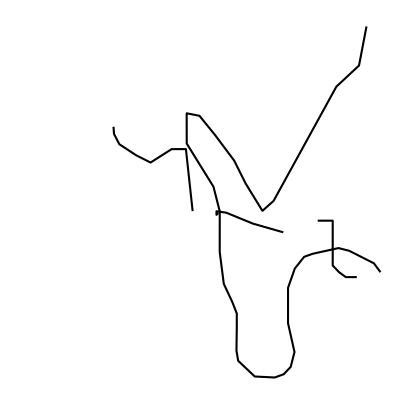

In [ ]:
def convert_to_5d(sample):
    """Converts a 3D sketch sample (Δx, Δy, pen_state) to 5D format."""
    sample = sample.squeeze(0)  # Remove batch dimension if present
    out = torch.zeros(sample.size(0), 5)
    out[:, :2] = sample[:, :2]  # Copy Δx and Δy
    out[:, 2] = 1 - sample[:, 2]  # p1 = 1 - pen_up
    out[:, 3] = sample[:, 2]      # p2 = pen_up
    out[:, 4] = 0                 # p3 = 0 (no end-of-sequence here)
    out[-1,4] = 1             # Set p3 to 1 for the last point (end of sequence)
    return out.unsqueeze(0)  # Restore batch dimension after conversion

# Load model
hps = hparams()
model = SketchRNN(hps)
model.load_state_dict(torch.load('results/model.pt'))  # Path to trained model
model.eval()

# Load test dataset
data_dir = 'data'  # Update with correct path if needed
_, _, test_strokes = load_strokes(data_dir, hps)
test_data = SketchRNNDataset(test_strokes, max_len=hps.max_seq_len)



# # Sample one sketch from test data
# sample_idx = torch.randint(0, len(test_data), (1,)).item()
# sample_sketch = test_data[sample_idx]  # Add batch dimension

# sample_sketch, lengths = collate_drawings([sample_sketch], hps.max_seq_len)  # Collate to max length
# sample_sketch = sample_sketch.squeeze(0)  # Remove batch dimension
# lengths = lengths.squeeze(0)  # Remove batch dimension

# sequence, penstate = sample_conditional(model, sample_sketch, lengths, device=torch.device('cpu'))  # Sample from model

# penstate = penstate.unsqueeze(-1)  # Expand the dimension of penstate
# sample_sketch = torch.cat((sequence, penstate), dim=-1)  # Concatenate sequence and penstate
# sample_sketch = convert_to_5d(sample_sketch)
# sample_sketch = sample_sketch.squeeze(0)  # Remove batch dimension

sample_sketch, penstate = sample_unconditional(model, z_scale=1, device=torch.device('cpu'))
penstate = penstate.unsqueeze(-1)  # Expand the dimension of penstate  # Sample from model
# # concatenate penstate to sample_sketch
sample_sketch = torch.cat((sample_sketch, penstate), dim=-1)  # [1, max_len, 5]
sample_sketch = convert_to_5d(sample_sketch)  # Convert to 5D format
sample_sketch = sample_sketch.squeeze(0)  # Remove batch dimension


def visualize_delta_drawing(delta_sequence):
    """Visualizes a drawing from delta format back to absolute coordinates."""
    x, y = 0, 0
    strokes = []
    current_stroke = [[],[]]

    for dx, dy, p1, p2, p3 in delta_sequence:
        x += dx
        y += dy

        if p1 > 0.5:  # Pen is down
            current_stroke[0].append(x)
            current_stroke[1].append(y)

        if p2 > 0.5:  # Pen is up - end of stroke
            if current_stroke[0]:  # If stroke has points
                strokes.append(current_stroke)
                current_stroke = [[],[]]
        if p3 > 0.5:
            break

    fig, ax = plt.subplots(figsize=(5, 5))
    for stroke in strokes:
        ax.plot(stroke[0], [-y for y in stroke[1]], 'k-')
    ax.axis('off')
    plt.show()

    return strokes

strokes = visualize_delta_drawing(sample_sketch.cpu().numpy())

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
import os
from pathlib import Path
from tqdm import tqdm


def class_to_latent_mapping(model, data_dir, output_dir, classes_to_process=None, batch_size=64,
                           max_samples_per_class=None, separate_files=True):
    """
    Extract latent vectors for specified classes from QuickDraw dataset and save them to JSON.

    Args:
        model: The trained model containing the encoder (accessible via model.encoder)
        data_dir: Directory containing QuickDraw .npz files
        output_dir: Directory to save the output JSON files
        classes_to_process: List of class names to process (e.g., ['apple', 'cat', ...])
        batch_size: Batch size for processing
        max_samples_per_class: Maximum number of samples to process per class
        separate_files: Whether to save each class to a separate JSON file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set up dummy hyperparameters for data loading
    class HParams:
        def __init__(self):
            self.max_seq_len = 250
            self.data_set = None

    hps = HParams()

    # Dictionary to store all class latent vectors
    all_class_vectors = {}

    # Set model to evaluation mode
    model.eval()
    device = next(model.parameters()).device

    # If no specific classes provided, search for all .npz files
    if not classes_to_process:
        npz_files = list(Path(data_dir).glob("*.npz"))
        if not npz_files:
            print(f"No .npz files found in {data_dir}")
            return
        print(f"Found {len(npz_files)} .npz files to process")
    else:
        # Process only the specified classes
        print(f"Processing {len(classes_to_process)} specified classes")
        npz_files = []
        for class_name in classes_to_process:
            # Look for different possible filename patterns
            patterns = [
                f"{class_name}.npz",
                f"full_numpy_bitmap_{class_name}.npz"
            ]

            found = False
            for pattern in patterns:
                file_path = Path(data_dir) / pattern
                if file_path.exists():
                    npz_files.append(file_path)
                    found = True
                    break

            if not found:
                print(f"Warning: Could not find .npz file for class '{class_name}'")

    # Process each class (npz file)
    for npz_file in npz_files:
        # Extract class name from filename
        class_name = os.path.splitext(os.path.basename(npz_file))[0]
        if class_name.startswith("full_numpy_bitmap_"):
            class_name = class_name.replace("full_numpy_bitmap_", "")

        # Skip if not in the specified list (extra check in case npz_files contains more than requested)
        if classes_to_process and class_name not in classes_to_process:
            continue

        print(f"Processing class: {class_name}")

        # Set up data loading for this class
        hps.data_set = str(npz_file.name)

        # Load strokes
        train_strokes, valid_strokes, _ = load_strokes(data_dir, hps)

        # Use training strokes for extracting latent vectors
        strokes_to_use = train_strokes
        if max_samples_per_class and len(strokes_to_use) > max_samples_per_class:
            # Randomly sample if we have a limit
            indices = np.random.choice(len(strokes_to_use), max_samples_per_class, replace=False)
            strokes_to_use = strokes_to_use[indices]

        # Create dataset
        dataset = SketchRNNDataset(strokes_to_use, max_len=hps.max_seq_len)

        # Process in batches
        latent_vectors = []

        # Use torch DataLoader for batching
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            collate_fn=lambda x: collate_drawings(x, hps.max_seq_len),
            shuffle=False
        )

        with torch.no_grad():
            for batch, lengths in tqdm(loader, desc=f"Extracting latents for {class_name}"):
                batch = batch.to(device)
                lengths = lengths.to(device)

                # Get latent vectors from encoder
                z, z_mean, z_logvar = model.encoder(batch, lengths)

                # We'll use the mean vector (z_mean) as our latent representation
                latent_vectors.append(z_mean.cpu().numpy())

        # Concatenate all batch results
        if latent_vectors:
            latent_vectors = np.concatenate(latent_vectors, axis=0)

            # Convert to list for JSON serialization
            latent_vectors_list = latent_vectors.tolist()

            if separate_files:
                # Save to a separate JSON file for this class
                output_file = os.path.join(output_dir, f"{class_name}_latent_vectors.json")
                with open(output_file, 'w') as f:
                    json.dump({class_name: latent_vectors_list}, f)
                print(f"Saved {len(latent_vectors_list)} latent vectors for {class_name} to {output_file}")
            else:
                # Add to combined dictionary
                all_class_vectors[class_name] = latent_vectors_list
                print(f"Processed {len(latent_vectors_list)} latent vectors for {class_name}")

    if not separate_files and all_class_vectors:
        # Save all classes to a single JSON file
        output_file = os.path.join(output_dir, "all_classes_latent_vectors.json")
        with open(output_file, 'w') as f:
            json.dump(all_class_vectors, f)
        print(f"Saved latent vectors for all classes to {output_file}")



# Define parameters
data_dir = 'data'
output_dir = "latent_vectors"
classes_to_process = ['cat','car']  # List your desired classes here

# Call the function
class_to_latent_mapping(
    model=model,
    data_dir=data_dir,
    output_dir=output_dir,
    classes_to_process=classes_to_process,
    batch_size=64,
    max_samples_per_class=50000,  # Limit to 50000 samples per class, for example
    separate_files=True  # Save each class to its own file
)

Processing 2 specified classes
Processing class: cat
Loading local file: data\cat.npz
Loaded 70000/2500/2500 from cat.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
hps.max_seq_len 129.
total drawings <= max_seq_len is 50000


Extracting latents for cat: 100%|██████████| 782/782 [00:35<00:00, 22.02it/s]


Saved 50000 latent vectors for cat to latent_vectors\cat_latent_vectors.json
Processing class: car
Loading local file: data\car.npz
Loaded 70000/2500/2500 from car.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
hps.max_seq_len 123.
total drawings <= max_seq_len is 50000


Extracting latents for car: 100%|██████████| 782/782 [00:36<00:00, 21.54it/s]


Saved 50000 latent vectors for car to latent_vectors\car_latent_vectors.json


Found 2 JSON files to process
Processing file: latent_vectors\car_latent_vectors.json
Calculated mean vector for car from 50000 samples
Processing file: latent_vectors\cat_latent_vectors.json
Calculated mean vector for cat from 50000 samples
Calculated mean latent vectors for 2 classes


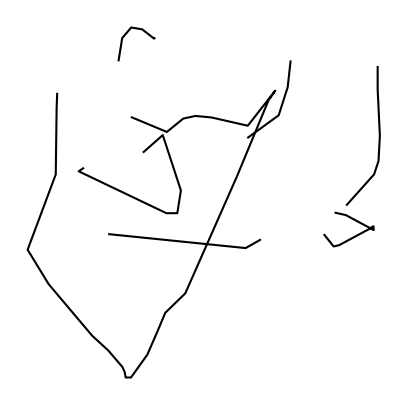

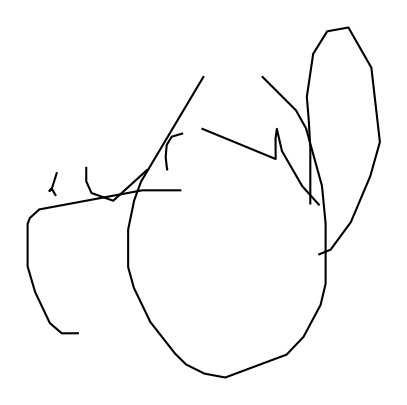

In [ ]:
def calculate_mean_latent_vectors(input_dir, output_file=None):
    """
    Load latent vectors from JSON files and calculate the mean vector for each class.

    Args:
        input_dir (str): Directory containing the JSON files with latent vectors
        output_file (str, optional): File path to save the mean vectors. If None, only returns the dictionary.

    Returns:
        dict: Dictionary with class names as keys and mean latent vectors as values
    """
    # Dictionary to store the mean latent vectors
    mean_latent_vectors = {}

    # Find all JSON files in the input directory
    json_files = list(Path(input_dir).glob("*_latent_vectors.json"))
    if not json_files:
        print(f"No latent vector JSON files found in {input_dir}")

        # Try looking for a combined file
        combined_file = Path(input_dir) / "all_classes_latent_vectors.json"
        if combined_file.exists():
            json_files = [combined_file]
            print(f"Found combined file: {combined_file}")
        else:
            return mean_latent_vectors

    print(f"Found {len(json_files)} JSON files to process")

    # Process each JSON file
    for json_file in json_files:
        print(f"Processing file: {json_file}")

        with open(json_file, 'r') as f:
            data = json.load(f)

        # Handle both separate and combined file formats
        if len(data.keys()) == 1 and json_file.name != "all_classes_latent_vectors.json":
            # Single class file format
            class_name = list(data.keys())[0]
            latent_vectors = np.array(data[class_name])

            if len(latent_vectors) > 0:
                # Calculate the mean vector for this class
                mean_vector = np.mean(latent_vectors, axis=0)
                mean_latent_vectors[class_name] = mean_vector.tolist()
                print(f"Calculated mean vector for {class_name} from {len(latent_vectors)} samples")
        else:
            # Combined file format or all_classes file
            for class_name, latent_vectors in data.items():
                latent_vectors = np.array(latent_vectors)

                if len(latent_vectors) > 0:
                    # Calculate the mean vector for this class
                    mean_vector = np.mean(latent_vectors, axis=0)
                    mean_latent_vectors[class_name] = mean_vector.tolist()
                    print(f"Calculated mean vector for {class_name} from {len(latent_vectors)} samples")

    print(f"Calculated mean latent vectors for {len(mean_latent_vectors)} classes")

    # Save the mean vectors to a JSON file if requested
    if output_file and mean_latent_vectors:
        os.makedirs(os.path.dirname(os.path.abspath(output_file)), exist_ok=True)
        with open(output_file, 'w') as f:
            json.dump(mean_latent_vectors, f)
        print(f"Saved mean latent vectors to {output_file}")

    return mean_latent_vectors


# Example usage:
input_dir = "latent_vectors"  # Directory containing JSON files with latent vectors
# output_file = "path/to/mean_latent_vectors.json"  # Where to save the mean vectors

# Calculate and save mean latent vectors
mean_vectors = calculate_mean_latent_vectors(input_dir)

# # You can now use mean_vectors dictionary for further processing
# # Example: Access the mean vector for a specific class
# if "banana" in mean_vectors:
#     cat_mean_vector = mean_vectors["banana"]
#     print(cat_mean_vector)
#     print(f"Mean vector for 'banana' has length: {len(cat_mean_vector)}")

# print(mean_vectors.keys())

z_cat = mean_vectors['cat']
z_cat = torch.tensor(z_cat, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
sequence_cat, penstate_cat = sample_from_z(model, z_cat, T=1)
penstate_cat = penstate_cat.unsqueeze(-1)  # Expand the dimension of penstate  # Sample from model
# concatenate penstate to sample_sketch
sample_sketch_cat = torch.cat((sequence_cat, penstate_cat), dim=-1)  # [1, max_len, 5]
sample_sketch_cat = convert_to_5d(sample_sketch_cat)  # Convert to 5D format
sample_sketch_cat = sample_sketch_cat.squeeze(0)  # Remove batch dimension

# visualize
strokes = visualize_delta_drawing(sample_sketch_cat.cpu().numpy())

z_car = mean_vectors['car']
z_car = torch.tensor(z_car, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
sequence_car, penstate_car = sample_from_z(model, z_car, T=1)
penstate_car = penstate_car.unsqueeze(-1)  # Expand the dimension of penstate
sample_sketch_car = torch.cat((sequence_car, penstate_car), dim=-1)  # [1, max_len, 5]
sample_sketch_car = convert_to_5d(sample_sketch_car)  # Convert to 5D format
sample_sketch_car = sample_sketch_car.squeeze(0)  # Remove batch dimension

# visualize
strokes_car = visualize_delta_drawing(sample_sketch_car.cpu().numpy())
